# Predicting Cancer Types from Gene Expression Profiles Using Machine Learning


In [33]:
# ================= BLOCK 1 — IMPORTS & CONFIG =================

from __future__ import annotations
import re
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    confusion_matrix
)

plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["figure.dpi"] = 110

# Path to your dataset
DATA_PATH = "GSE2034_series_matrix.txt"

# ML config
TEST_SIZE = 0.2
RANDOM_STATE = 42

# hint words used to detect outcome columns
TARGET_COL_HINTS = ["relapse", "metast", "bone", "event", "outcome", "distant"]

In [34]:
# ================= BLOCK 2 — EXPAND CHARACTERISTICS =================

def expand_characteristics_columns(meta: pd.DataFrame) -> pd.DataFrame:
    """
    Convert 'characteristics_ch1' entries like:
        'bone relapses (1=yes, 0=no): 0'
    into a proper column named:
        'bone_relapses_1_yes_0_no_'
    with values 0/1.
    """
    meta = meta.copy()
    char_cols = [c for c in meta.columns if "characteristics" in c.lower()]
    extracted: dict[str, pd.Series] = {}

    for c in char_cols:
        vals = meta[c].astype(str).fillna("")
        # split into key/value pairs
        pairs = vals.str.extract(r"^\s*([^:]+)\s*:\s*(.*)\s*$")

        if pairs.isna().all().all():
            continue

        keys = pairs[0].str.strip().str.lower().str.replace(r"\W+", "_", regex=True)
        values = pairs[1].str.strip()

        for k in keys.dropna().unique():
            mask = keys == k
            s = extracted.get(k, pd.Series(index=meta.index, dtype=object))
            s.loc[mask] = values.loc[mask]
            extracted[k] = s

    for k, s in extracted.items():
        meta[k] = s

    return meta

In [35]:
# ================= BLOCK 3 — CORE OOP CLASSES =================

@dataclass
class TrainResult:
    name: str
    report: str
    auc: float
    y_pred: np.ndarray
    y_prob: np.ndarray


class GeoSeriesMatrixLoader:
    """Load GEO series_matrix.txt and extract metadata + expression."""
    def __init__(self, path: str):
        self.path = path

    def load(self):
        # Read header lines
        with open(self.path, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()

        header_rows = {}

        for line in lines:
            if line.startswith("!Sample_"):
                parts = line.rstrip("\n").split("\t")
                # FIXED: slice at 8 instead of 9
                key = parts[0][8:].lower()
                vals = [p.strip().strip('"') for p in parts[1:]]
                header_rows[key] = vals

        # Load expression
        expr = pd.read_csv(self.path, sep="\t", comment="!", index_col=0)
        expr = expr[~expr.index.astype(str).str.startswith("!series_matrix_table_end")]
        expr = expr.apply(pd.to_numeric, errors="coerce")

        # Determine sample IDs
        gsm = header_rows.get("geo_accession", expr.columns.tolist())

        # Build metadata table
        meta = pd.DataFrame({k: pd.Series(v, index=gsm) for k, v in header_rows.items()})
        meta.index.name = "GSM"

        return meta, expr


class TargetFinder:
    """Finds and binarizes a target column (bone relapse)."""
    def __init__(self, hints):
        self.hints = [h.lower() for h in hints]
        self.chosen_col_ = None
        self.mapping = {
            "yes":1, "1":1, "true":1, "present":1, "positive":1,
            "no":0,  "0":0, "false":0, "negative":0, "absent":0, "none":0
        }

    def candidate_columns(self, meta):
        return [c for c in meta.columns if any(h in c.lower() for h in self.hints)]

    def choose_column(self, meta, override=None):
        if override:
            assert override in meta.columns, f"Column '{override}' not found in metadata."
            self.chosen_col_ = override
            return override

        cands = self.candidate_columns(meta)
        print("Candidate columns detected:", cands)

        assert cands, "No label-column found. Set target_override manually."
        self.chosen_col_ = cands[0]
        return self.chosen_col_

    def binarize(self, meta):
        col = self.chosen_col_
        assert col, "Run choose_column first."

        col_values = meta[col].astype(str).str.lower()
        col_values = col_values.str.replace(r".*?:", "", regex=True).str.strip()

        y = col_values.map(self.mapping)
        missing = y.isna()

        if missing.any():
            y.loc[missing] = col_values.loc[missing].apply(
                lambda v: 1 if any(k in v for k in ["yes","relapse","metast"]) else 0
            )

        return y.astype(int)


class Preprocessor:
    """Align and clean gene expression matrix."""
    def __init__(self, nan_thresh=0.2):
        self.nan_thresh = nan_thresh
        self.scaler = None

    def align(self, expr, meta, y):
        X = expr.T  # samples × genes
        common = X.index.intersection(meta.index).intersection(y.index)
        X = X.loc[common]
        y = y.loc[common]
        return X, y

    def clean(self, X):
        nan_frac = X.isna().mean()
        X = X.loc[:, nan_frac < self.nan_thresh]
        return X.fillna(X.median())

    def scale(self, X_train, X_test):
        self.scaler = StandardScaler()
        return self.scaler.fit_transform(X_train), self.scaler.transform(X_test)


class ModelTrainer:
    """Train LR and RF, evaluate them, plot results."""
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.lr = None
        self.rf = None

    def fit_logistic(self, X_train_s, y_train):
        self.lr = LogisticRegression(
            max_iter=1000, class_weight="balanced", random_state=self.random_state
        )
        self.lr.fit(X_train_s, y_train)
        return self.lr

    def fit_rf(self, X_train, y_train):
        self.rf = RandomForestClassifier(
            n_estimators=500, class_weight="balanced_subsample",
            random_state=self.random_state, n_jobs=-1
        )
        self.rf.fit(X_train, y_train)
        return self.rf

    def evaluate(self, model, X_test, y_test, name="Model"):
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, digits=3)
        auc = roc_auc_score(y_test, y_prob)
        return TrainResult(name, report, auc, y_pred, y_prob)

    @staticmethod
    def plot_roc(y_test, y_prob, title):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.plot([0,1],[0,1],"--")
        plt.title(title)
        plt.legend()
        plt.show()

    @staticmethod
    def plot_cm(y_test, y_pred, title):
        cm = confusion_matrix(y_test, y_pred)
        plt.figure()
        plt.imshow(cm, cmap="Blues")
        for i in range(2):
            for j in range(2):
                plt.text(j,i,cm[i,j],ha="center",va="center")
        plt.title(title)
        plt.show()

    def importance(self, X_train):
        imp = pd.Series(self.rf.feature_importances_, index=X_train.columns)
        top = imp.sort_values(ascending=False).head(20)
        top.plot(kind="barh")
        plt.title("Top 20 Important Genes (RandomForest)")
        plt.gca().invert_yaxis()
        plt.show()
        return top


class CancerRelapsePipeline:
    """Full pipeline with all steps combined."""
    def __init__(self, path, target_override=None):
        self.path = path
        self.target_override = target_override

        self.loader = GeoSeriesMatrixLoader(path)
        self.finder = TargetFinder(TARGET_COL_HINTS)
        self.pp = Preprocessor()
        self.trainer = ModelTrainer(RANDOM_STATE)

    def run(self):
        # Load metadata + expression
        meta, expr = self.loader.load()
        print("Raw metadata:", meta.shape)

        # Expand characteristics_ch1 into real columns
        meta = expand_characteristics_columns(meta)

        # Step 2: determine target column
        chosen = self.finder.choose_column(meta, override=self.target_override)
        y = self.finder.binarize(meta)
        print("Using target:", chosen)
        print("Label distribution:", y.value_counts().to_dict())

        # Step 3: align & clean
        X, y = self.pp.align(expr, meta, y)
        X = self.pp.clean(X)

        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
        )

        # Logistic Regression
        X_train_s, X_test_s = self.pp.scale(X_train, X_test)
        lr = self.trainer.fit_logistic(X_train_s, y_train)
        lr_res = self.trainer.evaluate(lr, X_test_s, y_test, "Logistic Regression")

        print("\n=== Logistic Regression ===")
        print(lr_res.report)
        print("AUC:", lr_res.auc)

        # Random Forest
        rf = self.trainer.fit_rf(X_train, y_train)
        rf_res = self.trainer.evaluate(rf, X_test, y_test, "Random Forest")

        print("\n=== Random Forest ===")
        print(rf_res.report)
        print("AUC:", rf_res.auc)

        # Plots
        self.trainer.plot_roc(y_test, lr_res.y_prob, "Logistic ROC")
        self.trainer.plot_cm(y_test, lr_res.y_pred, "Logistic Confusion Matrix")

        self.trainer.plot_roc(y_test, rf_res.y_prob, "RandomForest ROC")
        self.trainer.plot_cm(y_test, rf_res.y_pred, "RandomForest Confusion Matrix")

        # Feature importances
        top = self.trainer.importance(X_train)
        top.to_csv("top_genes_randomforest.csv")
        print("\nSaved top genes → top_genes_randomforest.csv")

In [36]:
# 1️⃣ Core Classes

class GeoSeriesMatrixLoader:
    """Load GEO series_matrix.txt and separate metadata + expression data."""
    def __init__(self, path: str):
        self.path = path
        self.meta_: Optional[pd.DataFrame] = None
        self.expr_: Optional[pd.DataFrame] = None

    def load(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        with open(self.path, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()

        header_rows: Dict[str, List[str]] = {}
        for line in lines:
            if line.startswith("!Sample_"):
                parts = line.split("\t")
                # FIX HERE: "!Sample_" is 8 characters long
                key = parts[0][8:].lower()
                vals = [p.strip().strip('"') for p in parts[1:]]
                header_rows[key] = vals

        gsm = header_rows.get("geo_accession")
        if gsm is None:
            expr_tmp = pd.read_csv(self.path, sep="\t", comment="!", index_col=0)
            gsm = expr_tmp.columns.tolist()

        meta = pd.DataFrame({k: pd.Series(v, index=gsm) for k, v in header_rows.items()})
        meta.index.name = "GSM"

        expr = pd.read_csv(self.path, sep="\t", comment="!", index_col=0, low_memory=False)
        expr = expr[~expr.index.astype(str).str.startswith("!series_matrix_table_end")]
        expr = expr.apply(pd.to_numeric, errors="coerce")

        self.meta_, self.expr_ = meta, expr
        return meta, expr


class TargetFinder:
    """Finds and binarizes a target column from metadata."""
    def __init__(self, hints: List[str]):
        self.hints = [h.lower() for h in hints]
        self.chosen_col_: Optional[str] = None
        # basic yes/no mapping
        self.mapping_ = {
            "yes": 1, "1": 1, "true": 1, "positive": 1,
            "present": 1, "metastasis": 1, "relapse": 1,
            "no": 0, "0": 0, "false": 0, "negative": 0,
            "absent": 0, "none": 0
        }

    def candidate_columns(self, meta: pd.DataFrame) -> List[str]:
        return [c for c in meta.columns if any(h in c.lower() for h in self.hints)]

    def choose_column(self, meta: pd.DataFrame, override: Optional[str] = None) -> str:
        if override and override in meta.columns:
            self.chosen_col_ = override
            return override
        cands = self.candidate_columns(meta)
        print("Candidate target columns (based on hints):")
        print(cands)
        assert cands, "No candidate target columns found; set target_override to a real column name."
        self.chosen_col_ = cands[0]
        print(f"→ Using '{self.chosen_col_}' as target column.")
        return self.chosen_col_

    def binarize(self, meta: pd.DataFrame) -> pd.Series:
        assert self.chosen_col_ is not None, "Run choose_column() first."
        y_raw = meta[self.chosen_col_].astype(str).str.strip().str.lower()

        # Remove any "key:" prefixes like "relapse: yes"
        y_raw = y_raw.str.replace(r".*?:", "", regex=True).str.strip()

        y = y_raw.map(self.mapping_)
        if y.isna().any():
            # fallback heuristic based on substrings
            y = y_raw.apply(
                lambda v: 1 if any(k in v for k in ["yes", "pos", "relapse", "metast"]) else 0
            )
        return y.astype(int)


class Preprocessor:
    """Aligns samples and cleans/normalizes expression data."""
    def __init__(self, nan_gene_thresh: float = 0.2):
        self.nan_gene_thresh = nan_gene_thresh
        self.scaler_: Optional[StandardScaler] = None

    def align(self, expr: pd.DataFrame, meta: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        # gene rows, sample columns → transpose to samples x genes
        X = expr.T
        # find common sample IDs
        common = X.index.intersection(meta.index).intersection(y.index)
        X = X.loc[common]
        y = y.loc[common]
        return X, y

    def clean(self, X: pd.DataFrame) -> pd.DataFrame:
        # drop genes with too many NaNs
        nan_frac = X.isna().mean()
        X = X.loc[:, nan_frac < self.nan_gene_thresh]
        # fill remaining NaNs with median
        X = X.fillna(X.median(numeric_only=True))
        return X

    def scale_train_test(self, X_train: pd.DataFrame, X_test: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        self.scaler_ = StandardScaler()
        X_train_s = self.scaler_.fit_transform(X_train)
        X_test_s = self.scaler_.transform(X_test)
        return X_train_s, X_test_s


@dataclass
class TrainResult:
    name: str
    report: str
    auc: float
    y_pred: np.ndarray
    y_prob: np.ndarray


class ModelTrainer:
    """Trains Logistic Regression and Random Forest models."""
    def __init__(self, random_state: int = 42):
        self.random_state = random_state
        self.lr_: Optional[LogisticRegression] = None
        self.rf_: Optional[RandomForestClassifier] = None

    def fit_logistic(self, X_train_s: np.ndarray, y_train: pd.Series) -> LogisticRegression:
        self.lr_ = LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            random_state=self.random_state
        )
        self.lr_.fit(X_train_s, y_train)
        return self.lr_

    def fit_rf(self, X_train: pd.DataFrame, y_train: pd.Series) -> RandomForestClassifier:
        self.rf_ = RandomForestClassifier(
            n_estimators=500,
            random_state=self.random_state,
            class_weight="balanced_subsample",
            n_jobs=-1
        )
        self.rf_.fit(X_train, y_train)
        return self.rf_

    def evaluate(self, name: str, model, X_test, y_test) -> TrainResult:
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, digits=3)
        auc = roc_auc_score(y_test, y_prob)
        return TrainResult(name, report, auc, y_pred, y_prob)

    @staticmethod
    def plot_roc(y_true, y_score, title: str):
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.plot([0, 1], [0, 1], "--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(title)
        plt.legend()
        plt.show()

    @staticmethod
    def plot_cm(y_true, y_pred, title: str):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure()
        plt.imshow(cm)
        for i in range(2):
            for j in range(2):
                plt.text(j, i, cm[i, j], ha="center", va="center")
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    def feature_importance_rf(self, feature_names: List[str], topk: int = 20) -> pd.Series:
        assert self.rf_ is not None, "RandomForest not trained."
        imp = pd.Series(self.rf_.feature_importances_, index=feature_names).sort_values(ascending=False)
        top = imp.head(topk)
        top.plot(kind="barh", title="Top Important Genes (RandomForest)")
        plt.gca().invert_yaxis()
        plt.show()
        return top


class CancerRelapsePipeline:
    """End-to-end pipeline for data loading, preprocessing, modeling, and reporting."""
    def __init__(
        self,
        data_path: str,
        target_override: Optional[str] = None,
        hints: Optional[List[str]] = None,
        test_size: float = 0.2,
        random_state: int = 42,
    ):
        self.data_path = data_path
        self.target_override = target_override
        self.hints = hints or TARGET_COL_HINTS
        self.test_size = test_size
        self.random_state = random_state

        self.loader = GeoSeriesMatrixLoader(self.data_path)
        self.finder = TargetFinder(self.hints)
        self.pp = Preprocessor()
        self.trainer = ModelTrainer(random_state=self.random_state)

    def run(self):
        # Step 1: Load
        meta, expr = self.loader.load()
        print("Raw metadata shape:", meta.shape)
        print("Expression shape:", expr.shape)

        # Step 1b: expand characteristics into separate columns
        meta = expand_characteristics_columns(meta)
        print("Expanded metadata shape:", meta.shape)

        # Step 2: Target column
        chosen = self.finder.choose_column(meta, override=self.target_override)
        y = self.finder.binarize(meta)
        print(f"\nTarget column used: {chosen}")
        print("Class distribution:", y.value_counts().to_dict())

        # Step 3: Align & clean
        X, y = self.pp.align(expr, meta, y)
        X = self.pp.clean(X)
        print("Aligned data shape (samples x genes):", X.shape)

        # Step 4: Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=self.test_size,
            stratify=y,
            random_state=self.random_state
        )

        # Step 5: Logistic Regression (with scaling)
        X_train_s, X_test_s = self.pp.scale_train_test(X_train, X_test)
        lr = self.trainer.fit_logistic(X_train_s, y_train)
        lr_res = self.trainer.evaluate("LogisticRegression", lr, X_test_s, y_test)
        print("\n[Logistic Regression Report]\n", lr_res.report)
        print("ROC-AUC (Logistic):", lr_res.auc)

        # Step 6: Random Forest (no scaling needed)
        rf = self.trainer.fit_rf(X_train, y_train)
        rf_res = self.trainer.evaluate("RandomForest", rf, X_test, y_test)
        print("\n[Random Forest Report]\n", rf_res.report)
        print("ROC-AUC (RandomForest):", rf_res.auc)

        # Step 7: Plots
        self.trainer.plot_roc(y_test, lr_res.y_prob, "Logistic Regression ROC")
        self.trainer.plot_cm(y_test, lr_res.y_pred, "Logistic Regression Confusion Matrix")
        self.trainer.plot_roc(y_test, rf_res.y_prob, "Random Forest ROC")
        self.trainer.plot_cm(y_test, rf_res.y_pred, "Random Forest Confusion Matrix")

        # Step 8: Feature importance
        top_rf = self.trainer.feature_importance_rf(X_train.columns.tolist())
        top_rf.to_csv("top_genes_randomforest.csv")
        print("Top features saved → top_genes_randomforest.csv")

Raw metadata shape: (286, 26)
Expression shape: (22283, 286)
Expanded metadata shape: (286, 27)

Target column used: bone_relapses_1_yes_0_no_
Class distribution: {0: 217, 1: 69}
Aligned data shape (samples x genes): (286, 22283)

[Logistic Regression Report]
               precision    recall  f1-score   support

           0      0.795     0.795     0.795        44
           1      0.357     0.357     0.357        14

    accuracy                          0.690        58
   macro avg      0.576     0.576     0.576        58
weighted avg      0.690     0.690     0.690        58

ROC-AUC (Logistic): 0.6948051948051948

[Random Forest Report]
               precision    recall  f1-score   support

           0      0.759     1.000     0.863        44
           1      0.000     0.000     0.000        14

    accuracy                          0.759        58
   macro avg      0.379     0.500     0.431        58
weighted avg      0.576     0.759     0.654        58

ROC-AUC (RandomForest

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

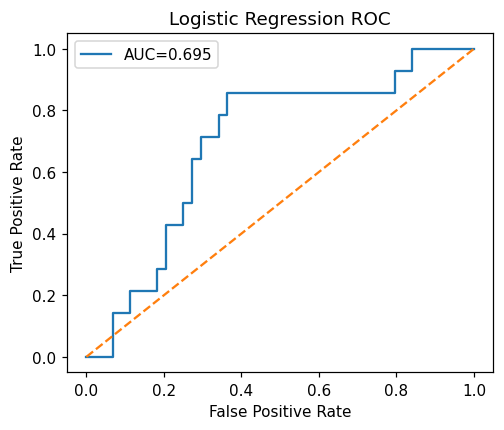

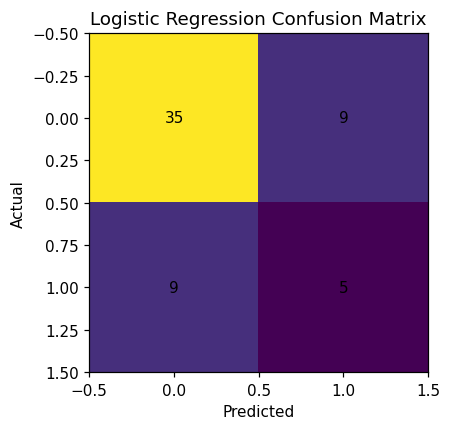

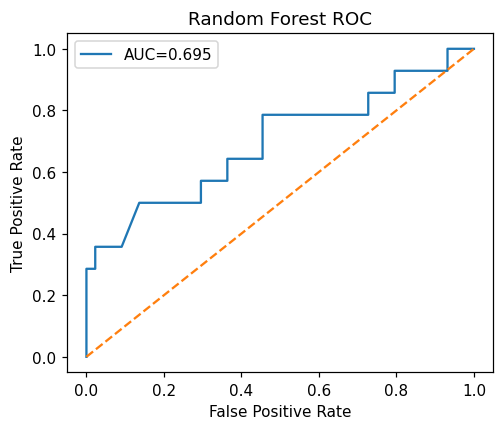

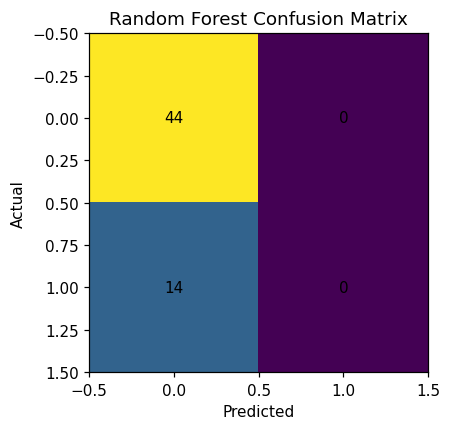

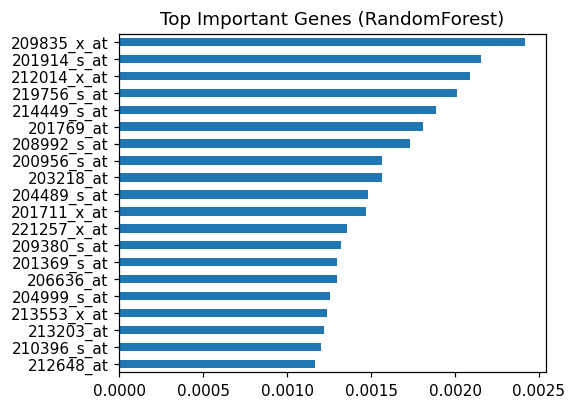

Top features saved → top_genes_randomforest.csv


In [38]:
# ================= BLOCK 4 — RUN PIPELINE =================

TARGET_OVERRIDE = "bone_relapses_1_yes_0_no_"   # CONFIRMED from your metadata

pipe = CancerRelapsePipeline(
    DATA_PATH,                 # ← positional, not path= 
    target_override=TARGET_OVERRIDE
)

pipe.run()